In [1]:
# Install Transformers
!pip install transformers==3
# To get model summary
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 754 kB 12.5 MB/s 
     |████████████████████████████████| 880 kB 34.3 MB/s 
     |████████████████████████████████| 1.2 MB 13.5 MB/s 
     |████████████████████████████████| 3.0 MB 16.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=4ad3965edccb003fc53f5d7c74a1bb2cd1195194c9113c6f08e3140a4fee8f6a
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
ls

sample_data/


In [3]:
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt

device = torch.device("cuda")

In [6]:
df = pd.read_csv("train_data.csv")
df.head()

,text,intent
0,Hi,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [7]:
df["intent"].value_counts()

course            34
fees              32
hostel            22
fest              21
scholarship       20
faculty           20
hours             17
creator           16
location          16
number            15
name              13
document          13
library           12
salutaion         12
admission         12
goodbye           12
event             11
infrastructure    11
canteen           10
swear              9
college intake     9
uniform            9
greeting           9
student portal     9
placement          8
ragging            8
faculty portal     7
sports             7
transport          7
principal          7
syllabus           7
task               6
facilities         5
menu               5
csehod             4
hod                3
random             3
other              1
Name: intent, dtype: int64

In [8]:
# Converting the labels into encodings
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['intent'] = le.fit_transform(df['intent'])

# check class distribution
df['intent'].value_counts(normalize = True)

3     0.076923
11    0.072398
16    0.049774
12    0.047511
30    0.045249
9     0.045249
17    0.038462
4     0.036199
20    0.036199
23    0.033937
22    0.029412
6     0.029412
19    0.027149
29    0.027149
0     0.027149
13    0.027149
7     0.024887
18    0.024887
1     0.022624
33    0.020362
2     0.020362
37    0.020362
14    0.020362
32    0.020362
25    0.018100
27    0.018100
10    0.015837
31    0.015837
36    0.015837
26    0.015837
34    0.015837
35    0.013575
8     0.011312
21    0.011312
5     0.009050
15    0.006787
28    0.006787
24    0.002262
Name: intent, dtype: float64

In [9]:
# In this example we have used all the utterances for training purpose
train_text, train_labels = df["text"], df["intent"]

In [10]:
from transformers import DistilBertTokenizer, DistilBertModel

In [11]:
# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [12]:
# Import the DistilBert pretrained model
bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

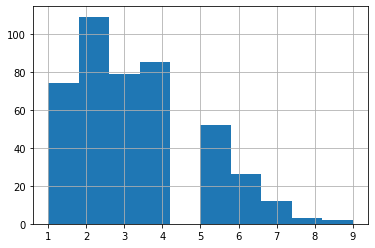

In [13]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 10)

# Based on the histogram we are selecting the max len as 8
max_seq_len = 8

In [14]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [15]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [17]:
#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [32]:
class BERT_Arch(nn.Module):
  def __init__(self, bert):      
       super(BERT_Arch, self).__init__()       
       self.bert = bert 
      
       # dropout layer
       self.dropout = nn.Dropout(0.2)
      
       # relu activation function
       self.relu =  nn.ReLU()     

       # dense layer       
       self.fc1 = nn.Linear(768,512)       
       self.fc2 = nn.Linear(512,256)       
       self.fc3 = nn.Linear(256,38)    

       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)      
      
   #define the forward pass
  def forward(self, sent_id, mask):      
      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)      

      # output layer
      x = self.fc3(x)
   
      # apply softmax activation
      x = self.softmax(x)     
      return x

In [33]:
# freeze all the parameters. This will prevent updating of model weights during fine-tuning.

for param in bert.parameters():
      param.requires_grad = False

model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BERT_Arch                                               --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           9,766
├─LogSoftmax: 1-7                                       --
Total 

In [34]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [35]:
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_wts = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
print(class_wts)

[ 0.96929825  1.16315789  1.29239766  0.34210526  0.72697368  2.90789474
  0.89473684  1.05741627  2.32631579  0.58157895  1.66165414  0.36348684
  0.55388471  0.96929825  1.29239766  3.87719298  0.52870813  0.68421053
  1.05741627  0.96929825  0.72697368  2.32631579  0.89473684  0.7754386
 11.63157895  1.45394737  1.66165414  1.45394737  3.87719298  0.96929825
  0.58157895  1.66165414  1.29239766  1.29239766  1.66165414  1.93859649
  1.66165414  1.29239766]


In [36]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

In [37]:
# loss function
cross_entropy = nn.NLLLoss(weight=weights) 

In [38]:
# empty lists to store training and validation loss of each epoch
train_losses=[]

# number of training epochs
epochs = 200

# We can also use learning rate scheduler to achieve better results
lr_sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [39]:
# function to train the model
def train():
  
  model.train()
  total_loss = 0
  
  # empty list to save model predictions
  total_preds=[]

   # iterate over batches
  for step,batch in enumerate(train_dataloader):
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # clear calculated gradients
    optimizer.zero_grad()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)#returns the loss and predictions
  return avg_loss, total_preds
  
 

In [41]:
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    # append training and validation loss
    train_losses.append(train_loss)   
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f'\nTraining Loss: {train_loss:.3f}')


 Epoch 1 / 200

Training Loss: 0.078

 Epoch 2 / 200

Training Loss: 0.067

 Epoch 3 / 200

Training Loss: 0.068

 Epoch 4 / 200

Training Loss: 0.086

 Epoch 5 / 200

Training Loss: 0.074

 Epoch 6 / 200

Training Loss: 0.042

 Epoch 7 / 200

Training Loss: 0.092

 Epoch 8 / 200

Training Loss: 0.078

 Epoch 9 / 200

Training Loss: 0.046

 Epoch 10 / 200

Training Loss: 0.049

 Epoch 11 / 200

Training Loss: 0.081

 Epoch 12 / 200

Training Loss: 0.061

 Epoch 13 / 200

Training Loss: 0.057

 Epoch 14 / 200

Training Loss: 0.044

 Epoch 15 / 200

Training Loss: 0.056

 Epoch 16 / 200

Training Loss: 0.057

 Epoch 17 / 200

Training Loss: 0.070

 Epoch 18 / 200

Training Loss: 0.052

 Epoch 19 / 200

Training Loss: 0.042

 Epoch 20 / 200

Training Loss: 0.071

 Epoch 21 / 200

Training Loss: 0.061

 Epoch 22 / 200

Training Loss: 0.039

 Epoch 23 / 200

Training Loss: 0.046

 Epoch 24 / 200

Training Loss: 0.051

 Epoch 25 / 200

Training Loss: 0.058

 Epoch 26 / 200

Training Loss: 0

In [45]:
def get_prediction(str):
 str = re.sub(r'[^a-zA-Z ]+', '', str)
 test_text = [str]
 model.eval()
 
 tokens_test_data = tokenizer(
 test_text,
 max_length = max_seq_len,
 pad_to_max_length=True,
 truncation=True,
 return_token_type_ids=False
 ) 
 test_seq = torch.tensor(tokens_test_data['input_ids'])
 test_mask = torch.tensor(tokens_test_data['attention_mask'])
 
 preds = None
 with torch.no_grad():
   preds = model(test_seq.to(device), test_mask.to(device))
   
 preds = preds.detach().cpu().numpy()
 preds = np.argmax(preds, axis = 1)
 print("Intent Identified: ", le.inverse_transform(preds)[0])
 return le.inverse_transform(preds)[0]
 


In [46]:
def get_response(message): 
  intent = get_prediction(message)
  return intent

In [52]:
get_response("Is hostel available there?")

Intent Identified:  hostel


'hostel'